# Check position image quality

In [1]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()

Local configuration file found !!, no need to run the configuration (unless configuration has changed)


In [2]:
import datajoint as dj
import os
import pathlib
import pandas as pd
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches


In [3]:
dj.conn()
action_db = dj.create_virtual_module('action', 'u19_action')

[2025-06-09 18:50:45,970][INFO]: Connecting alvaros@datajoint00.pni.princeton.edu:3306
[2025-06-09 18:50:47,639][INFO]: Connected alvaros@datajoint00.pni.princeton.edu:3306


### Load all images to test

In [4]:
query = dict()
query['location'] = '165A-miniVR-T-2'
AllImageRecords = pd.DataFrame((action_db.DailySubjectPositionData & query).fetch(as_dict=True))

In [7]:
AllImageRecords_copy = AllImageRecords.copy(deep=True)
AllImageRecords

,subject_fullname,capture_time,location,ml_position,ap_position,dv_position,lateral_image,top_image
0,efonseca_ef562_act122,2025-05-03 11:20:03,165A-miniVR-T-2,16.2049,20.394,11.5702,"[[143, 152, 150, 151, 152, 151, 149, 152, 151,...","[[13, 12, 11, 11, 11, 12, 13, 14, 13, 13, 13, ..."
1,efonseca_ef562_act122,2025-05-03 12:22:07,165A-miniVR-T-2,16.4049,20.394,11.5702,"[[153, 157, 155, 157, 156, 158, 161, 159, 159,...","[[7, 8, 9, 10, 9, 9, 9, 10, 8, 8, 8, 8, 9, 10,..."
2,efonseca_ef562_act122,2025-05-04 11:53:54,165A-miniVR-T-2,16.0049,20.394,11.5702,"[[145, 143, 142, 143, 142, 145, 144, 143, 146,...","[[14, 14, 13, 13, 14, 14, 15, 15, 14, 14, 14, ..."
3,efonseca_ef562_act122,2025-05-04 12:57:08,165A-miniVR-T-2,15.8049,20.394,11.5702,"[[153, 152, 152, 153, 156, 153, 159, 157, 155,...","[[7, 7, 7, 8, 9, 10, 10, 9, 10, 10, 9, 8, 8, 8..."
4,efonseca_ef562_act122,2025-05-05 10:56:08,165A-miniVR-T-2,16.0049,20.394,11.5702,"[[153, 152, 155, 155, 153, 153, 155, 152, 155,...","[[10, 11, 12, 14, 14, 13, 13, 12, 12, 13, 13, ..."
...,...,...,...,...,...,...,...,...
65,efonseca_ef562_act122,2025-06-07 11:28:23,165A-miniVR-T-2,14.8795,21.034,11.5702,"[[138, 135, 136, 137, 136, 140, 139, 139, 137,...","[[54, 53, 53, 53, 55, 56, 56, 55, 54, 54, 53, ..."
66,efonseca_ef562_act122,2025-06-08 10:37:27,165A-miniVR-T-2,14.8795,21.034,11.5702,"[[135, 137, 137, 136, 134, 135, 133, 134, 130,...","[[54, 51, 48, 46, 43, 41, 38, 37, 35, 34, 33, ..."
67,efonseca_ef562_act122,2025-06-08 11:28:27,165A-miniVR-T-2,14.8795,21.034,11.5702,"[[138, 136, 139, 140, 136, 139, 138, 139, 138,...","[[56, 54, 51, 49, 48, 47, 44, 42, 41, 37, 34, ..."
68,efonseca_ef562_act122,2025-06-09 10:34:21,165A-miniVR-T-2,14.8795,21.034,11.5702,"[[140, 135, 138, 140, 138, 138, 137, 140, 138,...","[[54, 52, 48, 43, 39, 35, 33, 32, 30, 28, 27, ..."


In [ ]:
#AllImageRecords = AllImageRecords_copy.copy(deep=True)

### Function to analyze image

In [40]:

def analyze_image_quality(_image, type='lateral'):
    #_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if type != 'lateral':
        _image = _image[:,200:600]

    # Sharpness
    _laplacian = cv2.Laplacian(_image, cv2.CV_64F)
    _sharpness = _laplacian.var()

    # Contrast
    _contrast = _image.std()

    # Clarity (using a simple combination of sharpness and contrast)
    _clarity = _sharpness * _contrast

    # Resolution (using Sobel operator)
    _sobel_x = cv2.Sobel(_image, cv2.CV_64F, 1, 0, ksize=5)
    _sobel_y = cv2.Sobel(_image, cv2.CV_64F, 0, 1, ksize=5)
    _sobel = np.sqrt(_sobel_x**2 + _sobel_y**2)
    _resolution = np.mean(_sobel)

    return {
        "sharpness": _sharpness,
        "clarity": _clarity,
        "resolution": _resolution
    }

In [41]:
AllImageRecords['top_image_metrics'] =  AllImageRecords['top_image'].apply(analyze_image_quality, type='top')
AllImageRecords['lateral_image_metrics'] =  AllImageRecords['lateral_image'].apply(analyze_image_quality, type='lateral')

In [42]:
df_aux = pd.json_normalize(AllImageRecords['top_image_metrics'])
df_aux = df_aux.rename(columns=lambda column: 'top_image_' + column)
AllImageRecords = pd.concat([AllImageRecords, df_aux], axis=1)

df_aux = pd.json_normalize(AllImageRecords['lateral_image_metrics'])
df_aux = df_aux.rename(columns=lambda column: 'lateral_image_' + column)
AllImageRecords = pd.concat([AllImageRecords, df_aux], axis=1)

AllImageRecords = AllImageRecords.drop(columns=['top_image_metrics', 'lateral_image_metrics'])
AllImageRecords

,subject_fullname,capture_time,location,ml_position,ap_position,dv_position,lateral_image,top_image,top_image_sharpness,top_image_clarity,top_image_resolution,lateral_image_sharpness,lateral_image_clarity,lateral_image_resolution
0,efonseca_ef562_act122,2025-05-03 11:20:03,165A-miniVR-T-2,16.2049,20.394,11.5702,"[[143, 152, 150, 151, 152, 151, 149, 152, 151,...","[[13, 12, 11, 11, 11, 12, 13, 14, 13, 13, 13, ...",9.827012,586.166982,348.642249,75.940354,3482.262729,192.500084
1,efonseca_ef562_act122,2025-05-03 12:22:07,165A-miniVR-T-2,16.4049,20.394,11.5702,"[[153, 157, 155, 157, 156, 158, 161, 159, 159,...","[[7, 8, 9, 10, 9, 9, 9, 10, 8, 8, 8, 8, 9, 10,...",20.409475,877.575516,307.947140,79.406748,3915.353091,201.481104
2,efonseca_ef562_act122,2025-05-04 11:53:54,165A-miniVR-T-2,16.0049,20.394,11.5702,"[[145, 143, 142, 143, 142, 145, 144, 143, 146,...","[[14, 14, 13, 13, 14, 14, 15, 15, 14, 14, 14, ...",45.698184,2822.632748,329.336322,73.416722,3271.911450,189.695659
3,efonseca_ef562_act122,2025-05-04 12:57:08,165A-miniVR-T-2,15.8049,20.394,11.5702,"[[153, 152, 152, 153, 156, 153, 159, 157, 155,...","[[7, 7, 7, 8, 9, 10, 10, 9, 10, 10, 9, 8, 8, 8...",10.997930,472.545172,243.200286,77.657872,3734.696507,201.750750
4,efonseca_ef562_act122,2025-05-05 10:56:08,165A-miniVR-T-2,16.0049,20.394,11.5702,"[[153, 152, 155, 155, 153, 153, 155, 152, 155,...","[[10, 11, 12, 14, 14, 13, 13, 12, 12, 13, 13, ...",8.634133,478.898686,246.334463,73.779223,3436.654945,191.887808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,efonseca_ef562_act122,2025-06-07 11:28:23,165A-miniVR-T-2,14.8795,21.034,11.5702,"[[138, 135, 136, 137, 136, 140, 139, 139, 137,...","[[54, 53, 53, 53, 55, 56, 56, 55, 54, 54, 53, ...",37.982432,2050.658548,275.407527,105.870113,4690.031099,289.901577
66,efonseca_ef562_act122,2025-06-08 10:37:27,165A-miniVR-T-2,14.8795,21.034,11.5702,"[[135, 137, 137, 136, 134, 135, 133, 134, 130,...","[[54, 51, 48, 46, 43, 41, 38, 37, 35, 34, 33, ...",42.246279,2229.746669,386.443831,101.481448,4577.261785,283.149384
67,efonseca_ef562_act122,2025-06-08 11:28:27,165A-miniVR-T-2,14.8795,21.034,11.5702,"[[138, 136, 139, 140, 136, 139, 138, 139, 138,...","[[56, 54, 51, 49, 48, 47, 44, 42, 41, 37, 34, ...",40.141916,2137.757984,274.203600,101.150222,4685.796087,275.085720
68,efonseca_ef562_act122,2025-06-09 10:34:21,165A-miniVR-T-2,14.8795,21.034,11.5702,"[[140, 135, 138, 140, 138, 138, 137, 140, 138,...","[[54, 52, 48, 43, 39, 35, 33, 32, 30, 28, 27, ...",50.410586,3055.303486,347.651146,106.812693,5185.970109,292.119541


### Plot image_sharpness 

Text(0.5, 1.0, 'Lateral Camera')

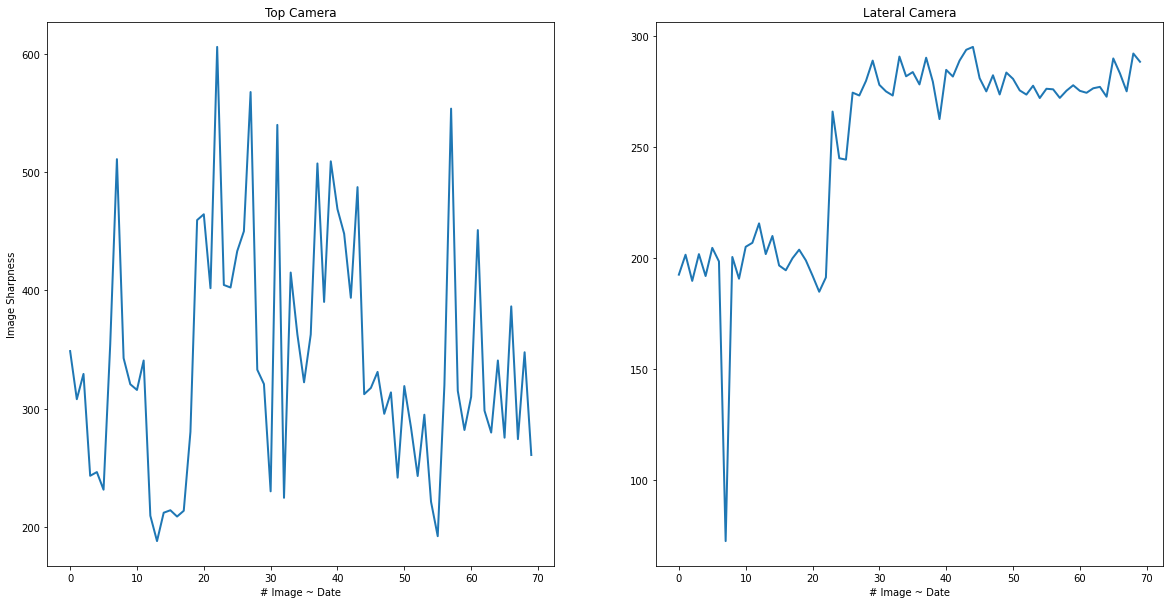

In [48]:
fig = plt.figure(figsize=(20, 10))

#fig, (ax1, ax2) = plt.subplots(1,2)
# plt.rcParams['figure.dpi'] = 250
fig.add_subplot(1, 2, 1)

plt.plot(AllImageRecords['top_image_resolution'], linewidth=2)
# Filter by using a moving average window of 10 samples
plt.xlabel('# Image ~ Date')
plt.ylabel('Image Sharpness')
plt.title('Top Camera')

fig.add_subplot(1, 2, 2)
plt.plot(AllImageRecords['lateral_image_resolution'], linewidth=2)
# Filter by using a moving average window of 10 samples
plt.xlabel('# Image ~ Date')

plt.title('Lateral Camera')

(-0.5, 719.5, 539.5, -0.5)

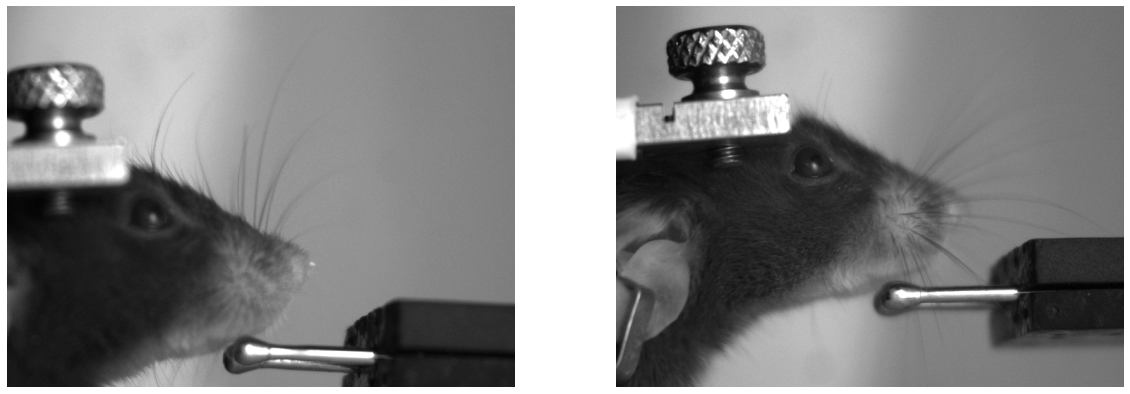

In [49]:
fig = plt.figure(figsize=(20, 10))



#fig, (ax1, ax2) = plt.subplots(1,2)
# plt.rcParams['figure.dpi'] = 250
fig.add_subplot(1, 2, 1)

plt.imshow(AllImageRecords.loc[5,'lateral_image'], cmap='gray')
plt.axis('off')


fig.add_subplot(1, 2, 2)
plt.imshow(AllImageRecords.loc[60,'lateral_image'], cmap='gray')
plt.axis('off')



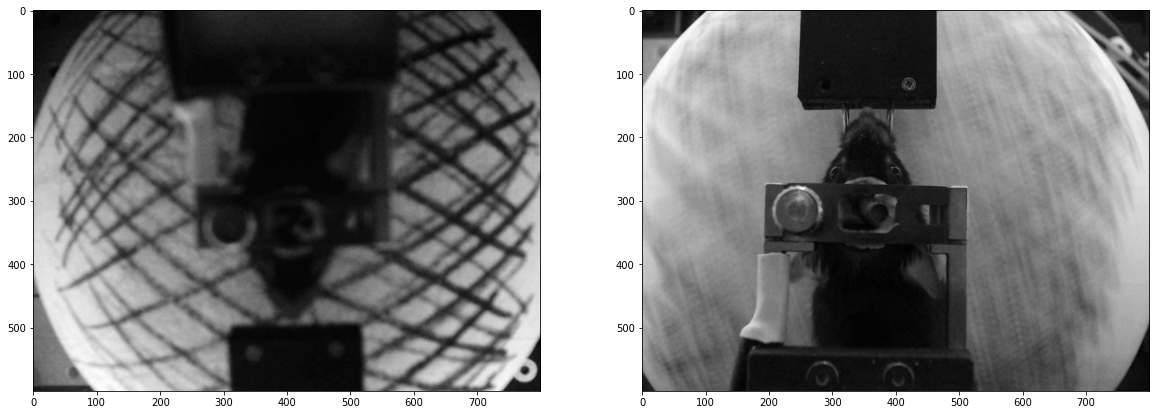

In [45]:
fig = plt.figure(figsize=(20, 10))



#fig, (ax1, ax2) = plt.subplots(1,2)
# plt.rcParams['figure.dpi'] = 250
fig.add_subplot(1, 2, 1)

plt.imshow(AllImageRecords.loc[5,'top_image'], cmap='gray')
#plt.axis('off')


fig.add_subplot(1, 2, 2)
plt.imshow(AllImageRecords.loc[59,'top_image'], cmap='gray')
#plt.axis('off')



(-0.5, 399.5, 599.5, -0.5)

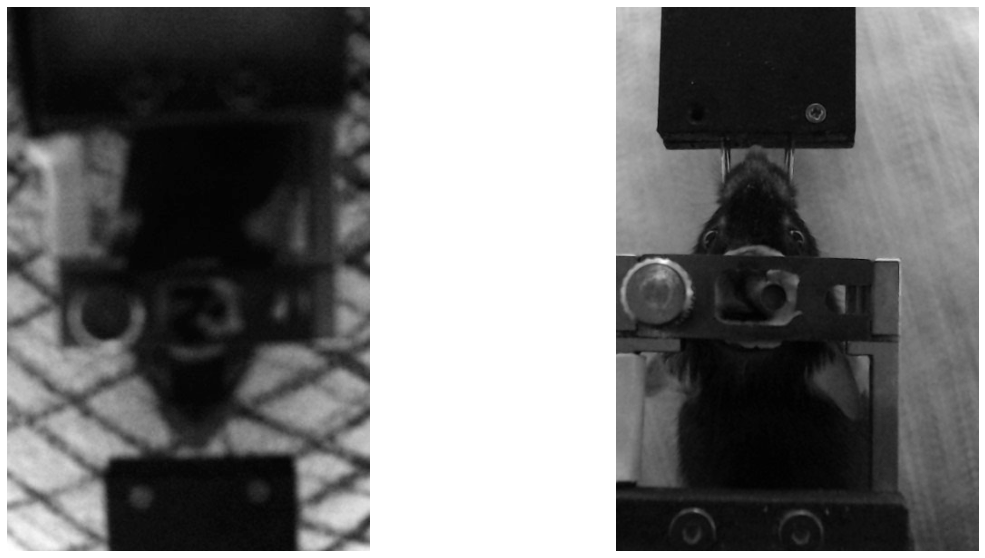

In [46]:
fig = plt.figure(figsize=(20, 10))



#fig, (ax1, ax2) = plt.subplots(1,2)
# plt.rcParams['figure.dpi'] = 250
fig.add_subplot(1, 2, 1)

plt.imshow(AllImageRecords.loc[5,'top_image'][:,200:600], cmap='gray')
plt.axis('off')


fig.add_subplot(1, 2, 2)
plt.imshow(AllImageRecords.loc[59,'top_image'][:,200:600], cmap='gray')
plt.axis('off')



In [36]:
AllImageRecords.loc[5,'top_image'].shape

(600, 800)

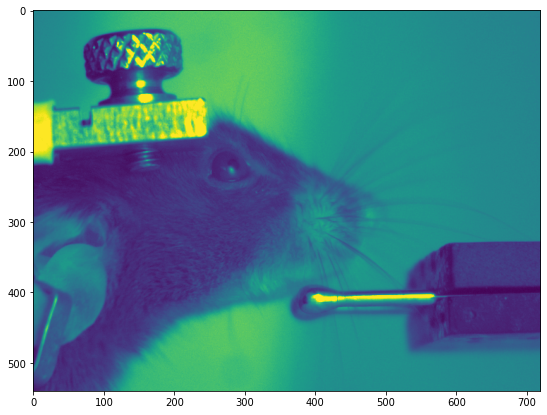

In [23]:
fig = plt.figure(figsize=(14, 7))
plt.imshow(AllImageRecords.loc[60,'lateral_image'])

In [61]:
import cv2

video_name = 'top_image_video4.mp4' # Name of the output video file

height, width = AllImageRecords.loc[0,'top_image'].shape

fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Codec for mp4 video
video = cv2.VideoWriter(video_name, fourcc, 5, (width, height), isColor=False) # 30 is the frame rate

for i in range(AllImageRecords.shape[0]):
    print(AllImageRecords.loc[i,'top_image'])

    video.write(AllImageRecords.loc[i,'top_image'])

video.release()

[[13 12 11 ... 13 13 13]
 [13 12 11 ... 14 13 13]
 [13 12 11 ... 14 14 13]
 ...
 [50 47 45 ... 23 23 22]
 [48 44 40 ... 21 21 22]
 [47 42 37 ... 19 20 21]]
[[ 7  8  9 ...  7  7  7]
 [ 7  9 11 ...  8  8  8]
 [ 8 10 12 ...  8  9  9]
 ...
 [21 20 21 ... 17 17 17]
 [21 19 19 ... 16 16 16]
 [22 20 19 ... 15 15 15]]
[[14 14 13 ... 16 14 12]
 [13 13 13 ... 14 13 12]
 [13 13 13 ... 13 13 12]
 ...
 [53 53 51 ... 27 26 24]
 [50 50 49 ... 24 23 21]
 [45 46 46 ... 24 24 22]]
[[ 7  7  7 ...  8  8  8]
 [ 9  8  8 ...  8  8  8]
 [10  9  9 ...  8  8  8]
 ...
 [27 28 27 ...  9  8  7]
 [25 25 25 ...  8  8  8]
 [24 24 24 ...  9  9  9]]
[[10 11 12 ...  9 12 15]
 [11 12 13 ...  9 11 13]
 [12 13 13 ... 10 10 10]
 ...
 [41 47 49 ... 37 37 38]
 [42 47 48 ... 41 41 41]
 [43 47 45 ... 44 45 45]]
[[ 8  8  8 ...  7  7  7]
 [ 9  8  8 ...  7  7  7]
 [10 10  9 ...  7  7  7]
 ...
 [22 22 21 ... 19 19 20]
 [25 24 22 ... 17 17 17]
 [26 24 22 ... 16 15 15]]
[[14 14 13 ... 12 14 15]
 [17 15 14 ... 13 13 14]
 [19 17 15 ...

In [54]:
width

720

In [76]:
outlierFrames

[]